## MergeNet architecture

Multi-stage training with weight-sharing, learning separately the low and high-level features from RGBD input and fusing them in a refining stage.

Trained and evaluated on Lost and Found dataset.

Combining both appearance cues (RGB) and depth information performs better in identifying small obstacles and it is less sensitive to missinterpreting markings and zebra crossings as obstacles on the road (which could also cause a change in the image gradients) as obstacle edges.

MergeNet can be trained on small dataset (135 images) and still obtain promising results.

Contains 3 networks:
  - stripe-net: fully convolutional encoder-decoder trained with vertical strips of RGBD input
    - learns low-level features from vertical pathways of road images
    - shares parameters across stripes to reduce complexity and overfitting
  - context-net: also a fully convolutional encoder-decoder but trained on the whole image
    - learns high-level features from a wider region than a stripe-width
  - refiner-net: aggregate low- and high-level features and make the final prediction

The encoder & decoder blocks used for upsampling and downsampling the image is based on the Segnet network's architecture.
    - encoder: downsamples the input image through a series of convolutions, batch normalization and pooling layers
    - decoder: upsamples the encoded features through series of deconvolutions, batch normalization and unpooling layers until it re-obtains the original input resolution



In [1]:
import numpy as np
import pydot
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import os
import shutil
from packaging import version
import sklearn.metrics
import PIL.Image as Image
from keras.utils import to_categorical
import segmentation_models as sm

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."

Segmentation Models: using `keras` framework.
TensorFlow version:  2.10.1


In [2]:
# test if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.experimental.get_device_details(physical_devices[0]))
logical_devices = tf.config.list_logical_devices('GPU')
print(logical_devices)
GPU_NAME = logical_devices[0].name
print("logical GPU name = ", GPU_NAME)

{'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
logical GPU name =  /device:GPU:0


## Build the model

In [3]:
def conv_layer(input, filters=64, kernel=(3,3), activation_fct="relu"):
    conv = layers.Conv2D(filters, kernel, padding="same", input_shape=input.shape[1:])(input)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Activation(activation_fct)(conv)
    return conv

def encoder_decoder(input_shape,
                    filters,
                    kernel=(3, 3),
                    pool_size=(2, 2)):
    inputs = layers.Input(shape=input_shape)
    inputs = layers.Rescaling(scale=1./255) (inputs)

    # encoder: 4 convolutional layers
    conv_1 = conv_layer(input=inputs, filters=filters, kernel=kernel, activation_fct="relu")
    pool_1 = layers.MaxPooling2D(pool_size)(conv_1)

    conv_2 = conv_layer(input=pool_1, filters=filters*2, kernel=kernel, activation_fct="relu")
    pool_2 = layers.MaxPooling2D(pool_size)(conv_2)

    conv_3 = conv_layer(input=pool_2, filters=filters*4, kernel=kernel, activation_fct="relu")
    pool_3 = layers.MaxPooling2D(pool_size)(conv_3)

    conv_4 = conv_layer(input=pool_3, filters=filters*8, kernel=kernel, activation_fct="relu")
    pool_4 = layers.MaxPooling2D(pool_size)(conv_4)

    # decoder: 4 convolutional layers
    unpool_1 = layers.UpSampling2D(pool_size)(pool_4)
    conv_5 = conv_layer(input=unpool_1, filters=filters*8, kernel=kernel, activation_fct="relu")

    unpool_2 = layers.UpSampling2D(pool_size)(conv_5)
    conv_6 = conv_layer(input=unpool_2, filters=filters*4, kernel=kernel, activation_fct="relu")

    unpool_3 = layers.UpSampling2D(pool_size)(conv_6)
    conv_7 = conv_layer(input=unpool_3, filters=filters*2, kernel=kernel, activation_fct="relu")

    unpool_4 = layers.UpSampling2D(pool_size)(conv_7)
    conv_8 = conv_layer(input=unpool_4, filters=filters, kernel=kernel, activation_fct="relu")

    model = keras.Model(inputs=inputs, outputs=conv_8)
    return model

def stripe_net(rgb_input_shape, depth_input_shape, nr_classes, k):
    rgb_enc_dec = encoder_decoder(input_shape=rgb_input_shape, filters=k//4, kernel=(3, 3), pool_size=(2, 2))
    depth_enc_dec = encoder_decoder(input_shape=depth_input_shape, filters=k//4, kernel=(3, 3), pool_size=(2, 2))
    concatenated = layers.Concatenate()([rgb_enc_dec.output, depth_enc_dec.output])
    output = layers.Conv2D(filters=nr_classes, kernel_size=(1,1), padding="same", activation="softmax") (concatenated)
    model = keras.Model(inputs=[rgb_enc_dec.input, depth_enc_dec.input], outputs=output, name='stripe_net')
    return model

def context_net(rgb_input_shape, nr_classes):
    rgb_enc_dec = encoder_decoder(input_shape=rgb_input_shape, filters=8, kernel=(3, 3), pool_size=(2, 2))
    final_conv = layers.Conv2D(filters=nr_classes, kernel_size=3, activation="softmax", padding="same")(rgb_enc_dec.output)
    model = keras.Model(inputs=rgb_enc_dec.input, outputs=final_conv, name='context_net')
    return model

def refiner_net(input_shape, nr_classes, filters=8, kernel=(3,3), pool_size=(2,2)):
    stripe_inputs = layers.Input(shape=input_shape, dtype=float)
    context_inputs = layers.Input(shape=input_shape, dtype=float)
    merged_inputs = layers.Concatenate(axis=2) ([stripe_inputs, context_inputs])

    conv_1 = conv_layer(input=merged_inputs, filters=filters, kernel=kernel, activation_fct="relu")
    pool_1 = layers.MaxPooling2D(pool_size)(conv_1)

    conv_2 = conv_layer(input=pool_1, filters=filters*2, kernel=kernel, activation_fct="relu")
    pool_2 = layers.MaxPooling2D(pool_size)(conv_2)

    unpool_1 = layers.UpSampling2D(pool_size)(pool_2)
    conv_3 = conv_layer(input=unpool_1, filters=filters*2, kernel=kernel, activation_fct="relu")

    unpool_2 = layers.UpSampling2D(pool_size)(conv_3)
    conv_4 = conv_layer(input=unpool_2, filters=filters, kernel=kernel, activation_fct="relu")

    final_conv = layers.Conv2D(filters=nr_classes, kernel_size=3, activation="softmax", padding="same", name="final_conv") (conv_4)
    output = tf.keras.backend.argmax(final_conv)
    model = keras.Model(inputs=merged_inputs, outputs=output, name='refiner_net')
    return model

## Load dataset

In [4]:
[train_ds, valid_ds, test_ds], info = tfds.load(name="lost_and_found/full", split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info=True)

In [5]:
train_ds.element_spec

{'disparity_map': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'image_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'image_left': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'image_right': TensorSpec(shape=(1024, 2048, 3), dtype=tf.uint8, name=None),
 'instance_id': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None),
 'segmentation_label': TensorSpec(shape=(1024, 2048, 1), dtype=tf.uint8, name=None)}

In [37]:
TRAIN_SIZE = train_ds.cardinality().numpy()
VALID_SIZE = valid_ds.cardinality().numpy()
TEST_SIZE = test_ds.cardinality().numpy()

print("Nr training instances = ", TRAIN_SIZE)
print("Nr validation instances = ", VALID_SIZE)
print("Nr test instances = ", TEST_SIZE)

Nr training instances =  829
Nr validation instances =  103
Nr test instances =  104


In [7]:
BATCH_SIZE = 4
BATCH_SIZE_STRIPE = 32
NR_CLASSES = 3
ORIG_HEIGHT = 1024
ORIG_WIDTH = 2048
IMG_HEIGHT = 256
IMG_WIDTH = 896
K = 28

In [168]:
def preprocess_input(dataset, batch_size, buffer_size, repeat_count, reshuffle=False):
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=reshuffle)
    dataset = dataset.repeat(repeat_count)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

def process_images(x, img_shape):
    x = tf.image.resize(x, img_shape)
    # result of resizing will be a float tensor
    x = x / 255.0
    return x

def encode_label(x):
    x = tf.math.minimum(x, [2])
    return x

def process_labels(x, img_shape):
    x = tf.image.resize(x, img_shape, method='nearest')
    x = tf.map_fn(encode_label, x)
    return x

def process_img_stripes(x, img_shape, k):
    x = process_images(x, img_shape)
    # create k stripes of fixed width
    x = tf.split(x, num_or_size_splits=k, axis=1)
    return x

def process_label_stripes(x, img_shape, k):
    x = process_labels(x, img_shape)
    # create k stripes of fixed width
    x = tf.split(x, num_or_size_splits=k, axis=1)
    return x

def prepare_images(ds, img_shape):
    input = ds.map(lambda x: (x['image_left'], x['disparity_map'], x['segmentation_label']))
    input = input.map(lambda x, y, z : (process_images(x, img_shape=img_shape),
                                        process_images(y, img_shape=img_shape),
                                        process_labels(z, img_shape=img_shape)))
    return input

def prepare_stripes(ds, img_shape, k):
    input = ds.map(lambda x: (x['image_left'], x['disparity_map'], x['segmentation_label']))
    input = input.flat_map(lambda x, y, z : tf.data.Dataset.from_tensor_slices((process_img_stripes(x, img_shape=img_shape, k=k),
                                                                                process_img_stripes(y, img_shape=img_shape, k=k),
                                                                                process_label_stripes(z, img_shape=img_shape, k=k))))
    input = input.map(lambda x, y, z: ((x,y), z))
    return input

In [119]:
train_stripes = prepare_stripes(train_ds, [IMG_HEIGHT, IMG_WIDTH], K)
valid_stripes = prepare_stripes(valid_ds, [IMG_HEIGHT, IMG_WIDTH], K)
test_stripes = prepare_stripes(test_ds, [IMG_HEIGHT, IMG_WIDTH], K)

train_img = prepare_images(train_ds, [IMG_HEIGHT, IMG_WIDTH])
valid_img = prepare_images(valid_ds, [IMG_HEIGHT, IMG_WIDTH])
test_img = prepare_images(test_ds, [IMG_HEIGHT, IMG_WIDTH])

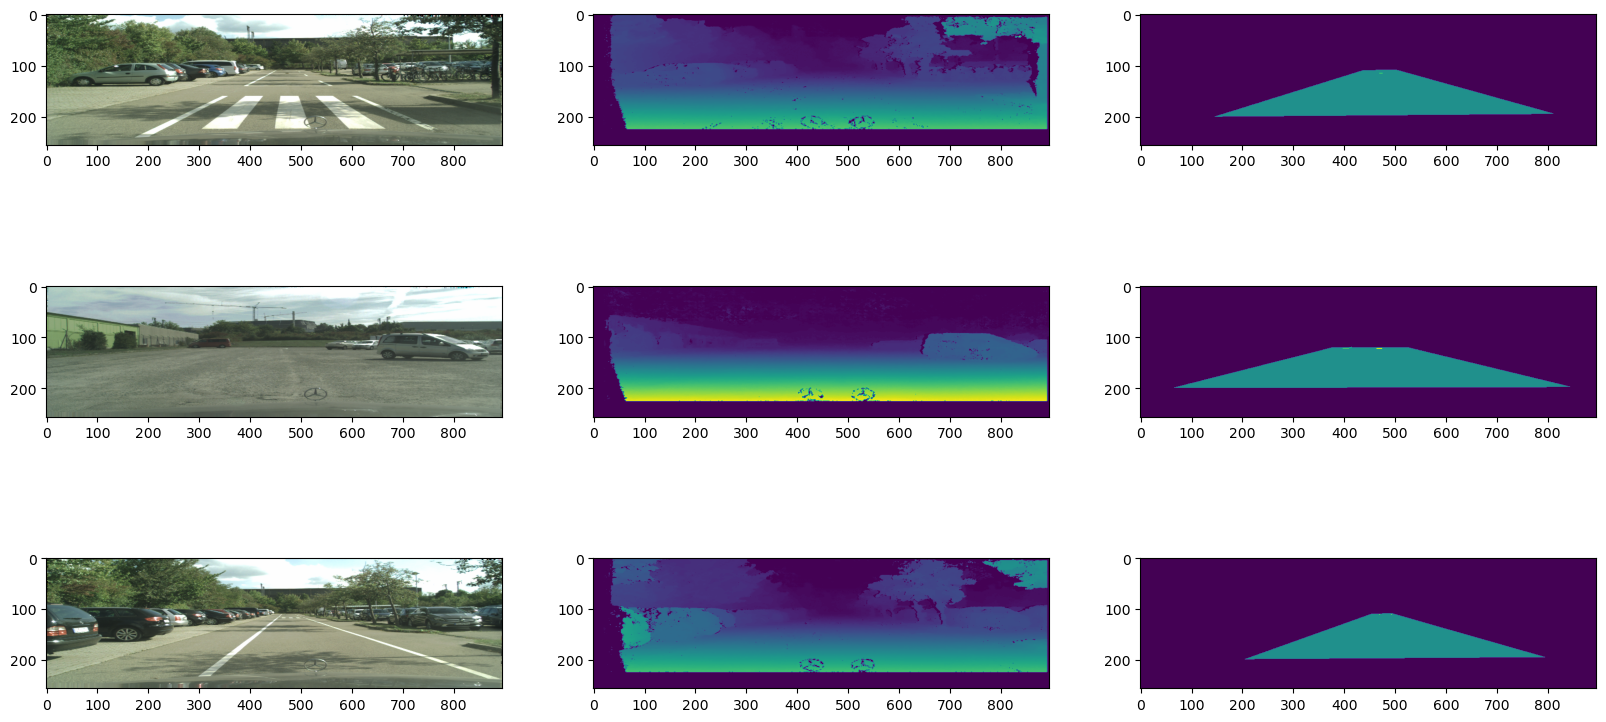

In [50]:
nr_samples = 3
fig, arr = plt.subplots(nr_samples, 3)
fig.set_figheight(10)
fig.set_figwidth(20)
i=0
for img, depth, label in train_img.as_numpy_iterator():
    arr[i, 0].imshow(img)
    arr[i, 1].imshow(depth)
    arr[i, 2].imshow(label)
    i+=1
    if i>=nr_samples:
        break

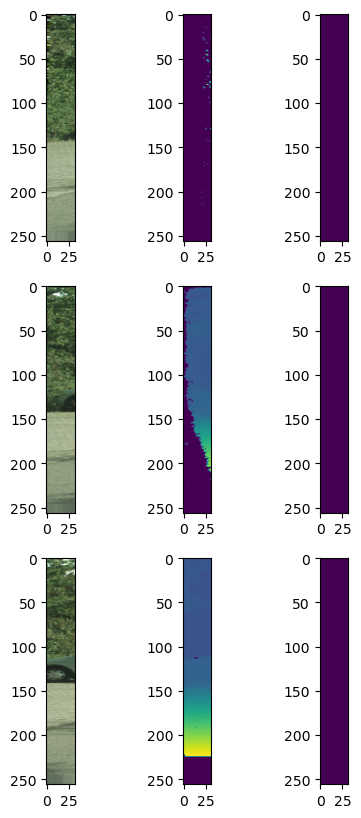

In [87]:
nr_samples = 3
fig, arr = plt.subplots(3, nr_samples)
fig.set_figheight(10)
fig.set_figwidth(5)
i=0
for (img, depth), label in train_stripes.as_numpy_iterator():
    arr[i, 0].imshow(img)
    arr[i, 1].imshow(depth)
    arr[i, 2].imshow(label)
    i += 1
    if i>=nr_samples:
        break

## Train the models

In [139]:
stripe_net_model = stripe_net(rgb_input_shape=(IMG_HEIGHT, IMG_WIDTH//K, 3),
                              depth_input_shape=(IMG_HEIGHT, IMG_WIDTH//K, 1),
                              nr_classes=NR_CLASSES,
                              k=K)
print(stripe_net_model.summary())

Model: "stripe_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 256, 32, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 input_46 (InputLayer)          [(None, 256, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_183 (Conv2D)            (None, 256, 32, 7)   196         ['input_44[0][0]']               
                                                                                         

In [140]:
stripe_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                         metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [142]:
EPOCHS = 20
BATCH_SIZE_STRIPE=32
train_stripes_batch = preprocess_input(train_stripes, BATCH_SIZE_STRIPE, buffer_size=TRAIN_SIZE*K, repeat_count=EPOCHS, reshuffle=True)
valid_stripes_batch = preprocess_input(valid_stripes, BATCH_SIZE_STRIPE, buffer_size=VALID_SIZE*K, repeat_count=EPOCHS, reshuffle=True)

In [143]:
filepath = "models/stripe_net.h5"
earlystopper = keras.callbacks.EarlyStopping(patience=3, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                             save_best_only=True, mode='min')
stripe_net_history = stripe_net_model.fit(train_stripes_batch,
                                          batch_size=BATCH_SIZE_STRIPE,
                                          shuffle=True,
                                          epochs=EPOCHS,
                                          steps_per_epoch=TRAIN_SIZE*K//BATCH_SIZE_STRIPE,
                                          callbacks=[earlystopper, checkpoint],
                                          validation_data=valid_stripes_batch)

Epoch 1/20
724/725 [============================>.] - ETA: 0s - loss: 0.1111 - sparse_categorical_accuracy: 0.9564
Epoch 1: val_loss improved from inf to 0.28150, saving model to models\stripe_net.h5
725/725 [==============================] - 75s 58ms/step - loss: 0.1111 - sparse_categorical_accuracy: 0.9564 - val_loss: 0.2815 - val_sparse_categorical_accuracy: 0.9090
Epoch 2/20
725/725 [==============================] - ETA: 0s - loss: 0.0876 - sparse_categorical_accuracy: 0.9646
Epoch 2: val_loss did not improve from 0.28150
725/725 [==============================] - 37s 52ms/step - loss: 0.0876 - sparse_categorical_accuracy: 0.9646 - val_loss: 1.1974 - val_sparse_categorical_accuracy: 0.8408
Epoch 3/20
725/725 [==============================] - ETA: 0s - loss: 0.0772 - sparse_categorical_accuracy: 0.9687
Epoch 3: val_loss improved from 0.28150 to 0.16601, saving model to models\stripe_net.h5
725/725 [==============================] - 38s 52ms/step - loss: 0.0772 - sparse_categorical

In [144]:
def plot_history(history, metric):
    plt.plot(history[metric])
    plt.plot(history['val_'+metric])
    plt.title('Model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [145]:
print(stripe_net_history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


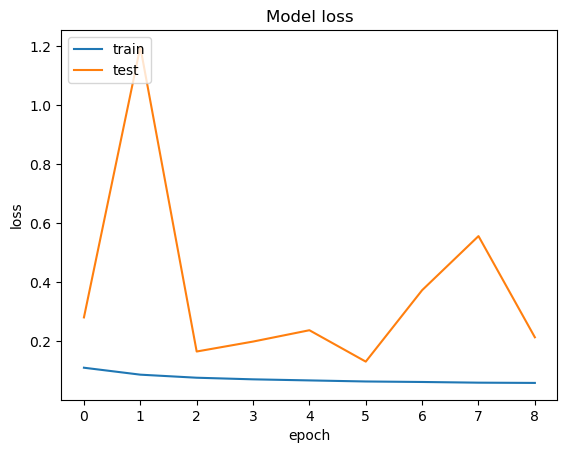

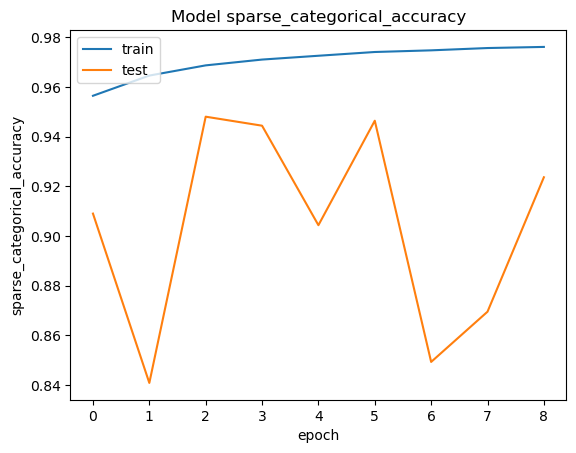

In [146]:
plot_history(stripe_net_history.history, 'loss')
plot_history(stripe_net_history.history, 'sparse_categorical_accuracy')

1/1 [==============================] - 0s 252ms/step


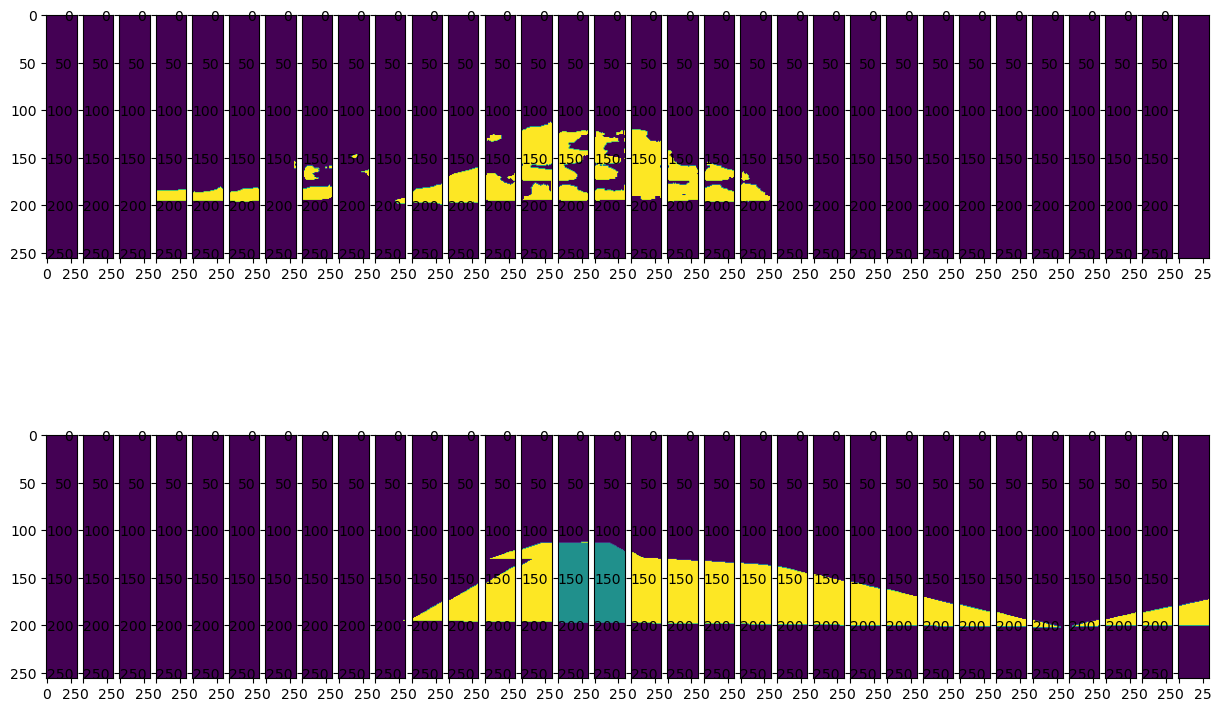

In [147]:
for data, label in test_stripes.batch(BATCH_SIZE_STRIPE).shuffle(BATCH_SIZE_STRIPE).as_numpy_iterator():
    pred_mask = stripe_net_model.predict(data)
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(2, BATCH_SIZE_STRIPE)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    for i in range(BATCH_SIZE_STRIPE):
        arr[0, i].imshow(pred_mask[i])
        arr[1, i].imshow(label[i])
    break

In [195]:
context_net_model = context_net(rgb_input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                nr_classes=NR_CLASSES)
print(context_net_model.summary())

Model: "context_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 256, 896, 3)]     0         
                                                                 
 conv2d_281 (Conv2D)         (None, 256, 896, 8)       224       
                                                                 
 batch_normalization_256 (Ba  (None, 256, 896, 8)      32        
 tchNormalization)                                               
                                                                 
 activation_256 (Activation)  (None, 256, 896, 8)      0         
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 128, 448, 8)      0         
 ng2D)                                                           
                                                                 
 conv2d_282 (Conv2D)         (None, 128, 448, 16)      

In [196]:
EPOCHS = 20
BATCH_SIZE=4
train_img_batch = preprocess_input(train_img, BATCH_SIZE, buffer_size=TRAIN_SIZE, repeat_count=EPOCHS)
valid_img_batch = preprocess_input(valid_img, BATCH_SIZE, buffer_size=VALID_SIZE, repeat_count=EPOCHS)

In [197]:
def count_pixels(x, label):
    x = x.flatten()
    return np.sum([x == label])

weights = []
# compute the class weights from a sample batch
for img, _, labels in train_img_batch.as_numpy_iterator():
    nr_background_pixels = count_pixels(labels, 0)
    nr_road_pixels = count_pixels(labels, 1)
    nr_obstacle_pixels = count_pixels(labels, 2)
    print("background : road : obstacle =", nr_background_pixels,":",nr_road_pixels,":",nr_obstacle_pixels)
    total_pixels = nr_background_pixels + nr_road_pixels + nr_obstacle_pixels
    # class weights are inversely proportional with the ratio of pixels of given class vs total pixels
    # the log is applied to smooth the weights for highly imbalanced classes
    weights=np.log([total_pixels/nr_background_pixels, total_pixels/nr_road_pixels, total_pixels/nr_obstacle_pixels])
    break

print(weights)

background : road : obstacle = 773558 : 143668 : 278
[0.17065629 1.85415186 8.1017911 ]


In [198]:
context_net_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          weighted_metrics=[keras.metrics.SparseCategoricalCrossentropy()],
                          metrics=[keras.metrics.SparseCategoricalAccuracy()],
                          loss_weights=[weights])

In [199]:
filepath = "models/context_net.h5"
earlystopper = keras.callbacks.EarlyStopping(patience=3, verbose=1)
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                             save_best_only=True, mode='min')

context_net_history = context_net_model.fit(train_img_batch,
                                            batch_size=BATCH_SIZE,
                                            epochs=EPOCHS,
                                            steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
                                            callbacks=[earlystopper, checkpoint],
                                            validation_data=valid_img_batch)

Epoch 1/20
207/207 [==============================] - ETA: 0s - loss: 0.0046 - sparse_categorical_accuracy: 0.2715 - sparse_categorical_crossentropy: 0.0083
Epoch 1: val_loss improved from inf to 0.00001, saving model to models\context_net.h5
207/207 [==============================] - 27s 122ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.2715 - sparse_categorical_crossentropy: 0.0083 - val_loss: 9.6190e-06 - val_sparse_categorical_accuracy: 0.2771 - val_sparse_categorical_crossentropy: 1.7807e-05
Epoch 2/20
207/207 [==============================] - ETA: 0s - loss: 1.8005e-05 - sparse_categorical_accuracy: 0.2729 - sparse_categorical_crossentropy: 3.2511e-05
Epoch 2: val_loss improved from 0.00001 to 0.00001, saving model to models\context_net.h5
207/207 [==============================] - 21s 104ms/step - loss: 1.8005e-05 - sparse_categorical_accuracy: 0.2729 - sparse_categorical_crossentropy: 3.2511e-05 - val_loss: 7.1349e-06 - val_sparse_categorical_accuracy: 0.2771 - val_sp

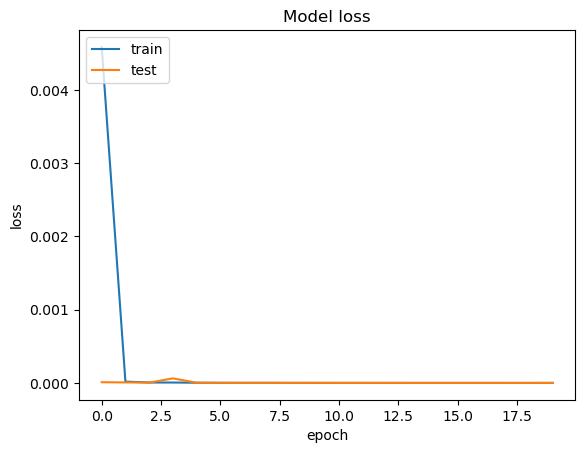

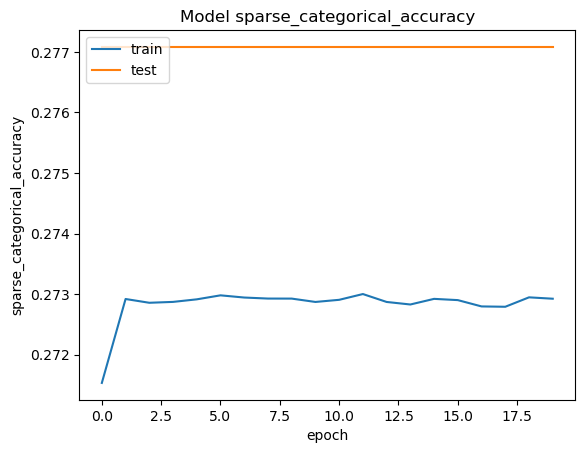

In [200]:
plot_history(context_net_history.history, 'loss')
plot_history(context_net_history.history, 'sparse_categorical_accuracy')

1/1 [==============================] - 0s 26ms/step


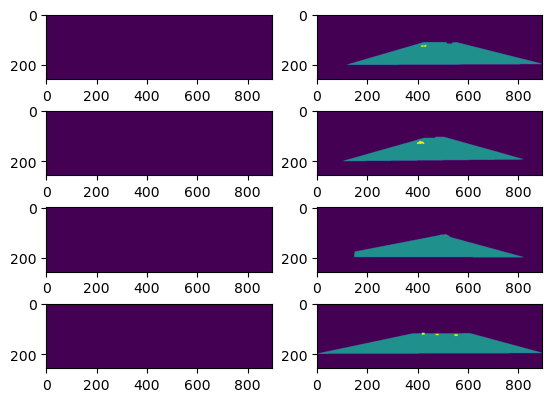

In [202]:
for data, _, label in test_img.shuffle(TEST_SIZE).batch(BATCH_SIZE).as_numpy_iterator():
    pred_mask = context_net_model.predict(data)
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(BATCH_SIZE,2)
    for i in range(BATCH_SIZE):
        arr[i, 0].imshow(pred_mask[i])
        arr[i, 1].imshow(label[i])
    break

In [124]:
refiner_net_model = refiner_net(input_shape=(IMG_HEIGHT, IMG_WIDTH, NR_CLASSES),
                                nr_classes=NR_CLASSES)
refiner_net_model.summary()

Model: "refiner_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 256, 1792, 3)]    0         
                                                                 
 conv2d_308 (Conv2D)         (None, 256, 1792, 8)      224       
                                                                 
 batch_normalization_294 (Ba  (None, 256, 1792, 8)     32        
 tchNormalization)                                               
                                                                 
 activation_294 (Activation)  (None, 256, 1792, 8)     0         
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 128, 896, 8)      0         
 ng2D)                                                           
                                                                 
 conv2d_309 (Conv2D)         (None, 128, 896, 16)      